# Working with Raw Data 

This section will serve as a tutorial on how to analyze and visualize data stored in the Allen Brain Mouse Connectivity Atlas. This section will cover how to download and visualize raw data as well as create projection matrices. 

## Setup

In [1]:
# Import common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
print('Packages imported.')

Packages imported.


In [2]:
# Import the MouseConnectivityCache
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

# Create an instance of the class and assign it to a variable, mcc
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
print(mcc)

As we showed in [the previous notebook](https://neuraldatascience.github.io/Chapter_8/Downloading_Experimental_Data.html), we can pull experiments based on the transgenic mouse line or the injection site. Below, we'll get a list of experiments where virus was injected into the visual cortex.

In [3]:
# Grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

# Select cortical experiments 
isocortex = structure_tree.get_structures_by_name(['Isocortex'])[0]
thalamus = structure_tree.get_structures_by_name(['Thalamus'])[0]

# Find injections into primary visual cortex 
VISp = structure_tree.get_structures_by_name(['Primary visual area'])[0]
VISp_experiments = mcc.get_experiments(cre=['Tlx3-Cre_PL56'],injection_structure_ids=[VISp['id']],dataframe=True)
print("%d Primary visual area experiments" % len(VISp_experiments))
VISp_experiments.head()

20 Primary visual area experiments


,gender,injection_structures,injection_volume,injection_x,injection_y,injection_z,product_id,specimen_name,strain,structure_abbrev,structure_id,structure_name,transgenic_line,transgenic_line_id,id,primary_injection_structure
id,,,,,,,,,,,,,,,,
510581751,M,[385],0.031653,9230,1390,3070,36,Tlx3-Cre_PL56-232871,None,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449,510581751,385
528963991,M,[385],0.036404,9560,1550,3190,35,Tlx3-Cre_PL56-252236,None,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449,528963991,385
540146149,M,[385],0.039305,9060,1340,3420,35,Tlx3-Cre_PL56-259156,None,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449,540146149,385
297593235,M,[385],0.014275,9440,1230,7990,5,Tlx3-Cre-125625,None,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449,297593235,385
522408611,M,[385],0.030385,8650,1380,3140,36,Tlx3-Cre_PL56-244757,B6.FVB,VISp,385,Primary visual area,Tlx3-Cre_PL56,265180449,522408611,385


## Plot the projection density for an experiment 

Before we look at the calculated projection density for multiple brain areas, let's take a look at the raw data. 
Using a feature of the MouseConnectivityCache, we can show an example of what an image of fluorescence would look like for a given experiment. The code below demonstrates how you can load the projection density for a particular experiment.

In [4]:
# Define an experiment of interest 
experiment_id = VISp_experiments.index[1]

# Get the projection density: number of projecting pixels / voxel volume
projection_density, pd_info = mcc.get_projection_density(experiment_id)

# Injection density: number of projecting pixels in injection site / voxel volume
ind, ind_info = mcc.get_injection_density(experiment_id)

2021-04-13 23:25:50,809 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/528963991?image=projection_density&resolution=25


2021-04-13 23:25:56,357 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/grid_data/download_file/528963991?image=injection_density&resolution=25


Now that we have a `projection_density` object for the entire brain, we can project this onto one plane for visualization. Below, we'll create a maximum intensity image of the projections (left) as well as the injection site (right). 

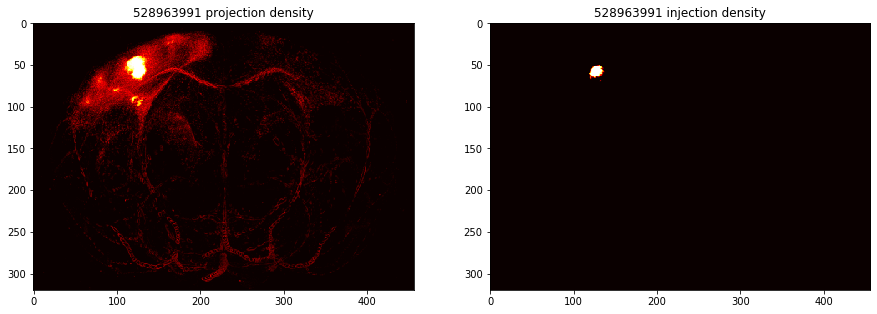

In [5]:
#Compute the maximum intensity projection of the projection data
pd_mip = projection_density.max(axis=0)
ind_mip = ind.max(axis=0)

#Show that slice of all volumes side-by-side
f, pr_axes = plt.subplots(1, 2, figsize=(15, 6))

pr_axes[0].imshow(pd_mip, cmap='hot', aspect='equal')
pr_axes[0].set_title(str(experiment_id)+ ' projection density')

pr_axes[1].imshow(ind_mip, cmap='hot', aspect='equal')
pr_axes[1].set_title(str(experiment_id) + ' injection density')

plt.show()

## Download and visualize gridded projection signal volumes
Given the variability in injection sites and virus expression, often, we'll want to look across multiple experiments to see the consistency in projection patterns. To do, we can use the **ProjectStructureUnionizes API**. 

The ProjectionStructureUnionizes API data tells you how much signal there was in a given structure and experiment. In this data, the "signal" is the fluorescence from our viral tracers. This data contains the density of projecting signal, volume of projecting signal, and other information. [MouseConnectivityCache](https://alleninstitute.github.io/AllenSDK/allensdk.core.mouse_connectivity_cache.html) provides methods for querying and storing this data. To access to this signal projection data, you must call the [`get_structure_unionizes()`](https://alleninstitute.github.io/AllenSDK/unionizes.html) method on our MouseConnectivityCache instance.

*Note*: Since this is pulling quite a bit of data, it may take a minute or two.

In [6]:
VISp_expt_IDs = VISp_experiments.index.tolist()

# Download projection signals for structure of interest 
structure_unionizes = mcc.get_structure_unionizes(experiment_ids = VISp_expt_IDs, 
                                                  is_injection=False,
                                                  structure_ids=[isocortex['id']],
                                                  include_descendants=True)

#print("%d Primary visual area non-injection, cortical structure unionizes" % len(structure_unionizes))

structure_unionizes.head()

As you can see, `structure_unionizes` is a very large dataframe filled with all the signal projection data for our experiments of interest. We can filter this like any other dataframe. For example, we can filter the dataframe to only include experiments with a large projection density and volume. For the purposes of this lesson, we will consider any `projection_density` and `volume` greater than 0.3 to be *large*. 

In [7]:
# Only include experiments that have a large projection density 
dense_unionizes = structure_unionizes[structure_unionizes['projection_density'] > .1 ]

# Only include experiments from the dense dataframe that have a large volume 
large_unionizes = dense_unionizes[dense_unionizes['volume'] > .1 ]

# create a dataframe that contains metadata from structure IDs within our large and dense df
large_structures = pd.DataFrame(structure_tree.nodes(large_unionizes['structure_id']))

print("%d large, dense, cortical, non-injection unionizes, %d structures" % ( len(large_unionizes), len(large_structures) ))

# return all large, dense, cortical, structure unionizes 
print(large_structures['name'])

large_unionizes.head()

100 large, dense, cortical, non-injection unionizes, 100 structures
0     Posterolateral visual area, layer 2/3
1       Posterolateral visual area, layer 5
2      posteromedial visual area, layer 2/3
3       Posterolateral visual area, layer 1
4            Lateral visual area, layer 2/3
                      ...                  
95               Posterolateral visual area
96                             Visual areas
97                      Lateral visual area
98             Lateral visual area, layer 1
99     posteromedial visual area, layer 2/3
Name: name, Length: 100, dtype: object


,experiment_id,hemisphere_id,id,is_injection,max_voxel_density,max_voxel_x,max_voxel_y,max_voxel_z,normalized_projection_volume,projection_density,projection_energy,projection_intensity,projection_volume,structure_id,sum_pixel_intensity,sum_pixels,sum_projection_pixel_intensity,sum_projection_pixels,volume
963,528963991,1,640923314,False,0.965165,10120,2020,2440,0.430990,0.138737,145.824844,1051.085083,0.015690,269,3.683764e+10,92317504.0,1.346218e+10,12807892.0,0.113089
1074,528963991,1,640922539,False,0.627521,9950,2210,3030,0.374743,0.101921,85.999184,843.786133,0.013642,902,3.866964e+10,109265400.0,9.396735e+09,11136394.0,0.133850
1207,528963991,1,640923537,False,0.866392,8370,590,4050,0.494574,0.111774,102.610947,918.022888,0.018004,41,4.309624e+10,131492704.0,1.349259e+10,14697445.0,0.161079
1216,528963991,1,640922708,False,0.960862,10200,2300,2990,0.385278,0.131293,185.141693,1410.141602,0.014026,750,3.585668e+10,87205504.0,1.614538e+10,11449471.0,0.106827
1313,528963991,1,640922434,False,0.754404,9060,1630,2000,0.560690,0.122774,125.017197,1018.268982,0.020411,973,5.379557e+10,135714592.0,1.696666e+10,16662256.0,0.166250


## Build a structure-to-structure matrix of projection signal values

The MouseConnectivityCache class provides a helper method for converting ProjectionStructureUnionize data for a set of experiments and structures into a matrix. This is done by calling [`get_projection_matrix`](https://alleninstitute.github.io/AllenSDK/allensdk.core.mouse_connectivity_cache.html#allensdk.core.mouse_connectivity_cache.MouseConnectivityCache.get_projection_matrix) on our MouseConnectivityCache instance. The method can take in arguements `experiment_ids`, `projection_structure_ids`, `hemisphere_ids`, `parameter`, and `dataframe` to further specify your matrix.

The code below demonstrates how to make a matrix of projection density values in auditory sub-structures for injections into VISp.

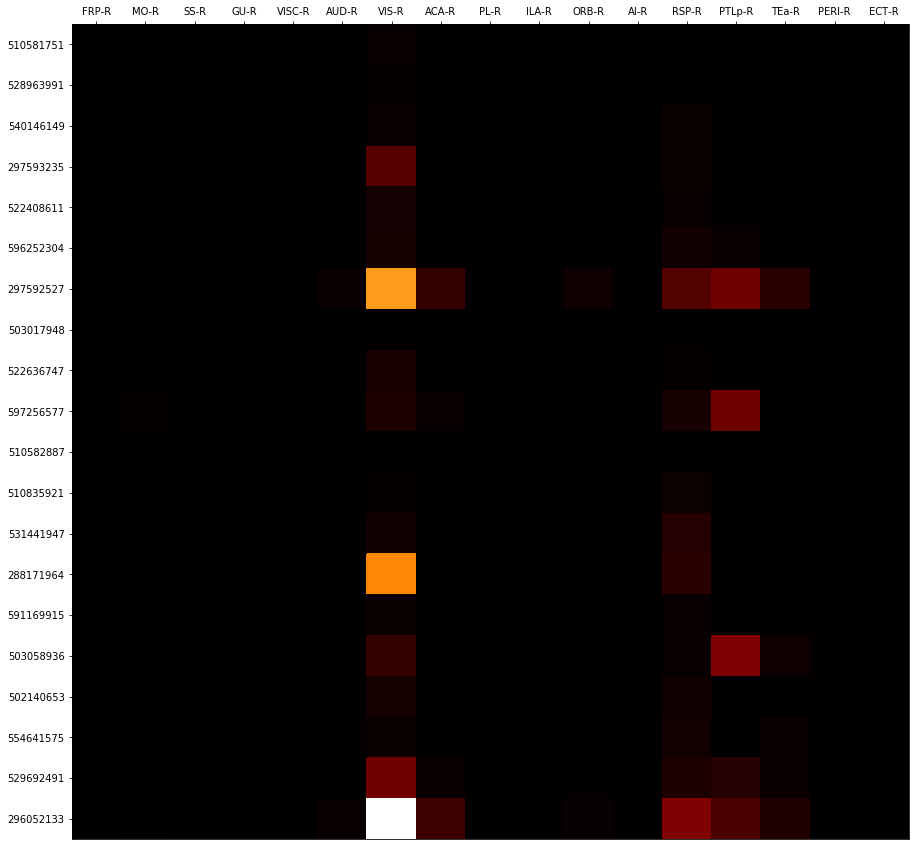

In [8]:
ctx_children = structure_tree.child_ids([isocortex['id']])[0]

# Create your projection matrix 
pm = mcc.get_projection_matrix(experiment_ids = VISp_expt_IDs, 
                               projection_structure_ids = ctx_children,
                               hemisphere_ids= [2], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

# These are just experiment ids
row_labels = pm['rows'] 

# These are the brain structures 
column_labels = [ col['label'] for col in pm['columns'] ]

matrix = pm['matrix']

# Plot your matrix 
fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# Put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# Want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

## Additional Resources 

For more information on all the functions used to download the projection signals and create the projection matrices, please look at the <a href = 'https://alleninstitute.github.io/AllenSDK/allensdk.core.mouse_connectivity_cache.html'> original documentaion</a>. For information on how to create heat maps like the one created for the flourecense image, please visit the <a href = 'https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.imshow.html'> matplotlib documentation</a>.